# Heart Disease Classification 

1. Problem Definition: Create ML model to predict if a person has heart disease
2. Data: From kaggle ("https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease")
3. Evaluation: Predict with 90% accuracy
4. Features: BMI, Smoking, Alcohol Drinking, Stroke, Physical Health, Mental Health, Diff Walking, Sex, Age Category, Race, Diabetic, Physical Activity, Gen Health, Sleep Time, Asthma, Kidney Disease, Skin Cancer

In [1]:
# Importing tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle

In [2]:
# Loading data into dataframe
heart_df = pd.read_csv("heart_disease_data.csv")
heart_df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Exploring the data

In [3]:
# Check amount of data
len(heart_df)

319795

In [4]:
heart_df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [5]:
# Check for missing data
heart_df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [6]:
# Check for biases in data
heart_df["HeartDisease"].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

There is a significant amount of "no" heart disease than "yes", so the training data should be randomly under-sampled

## Graphs

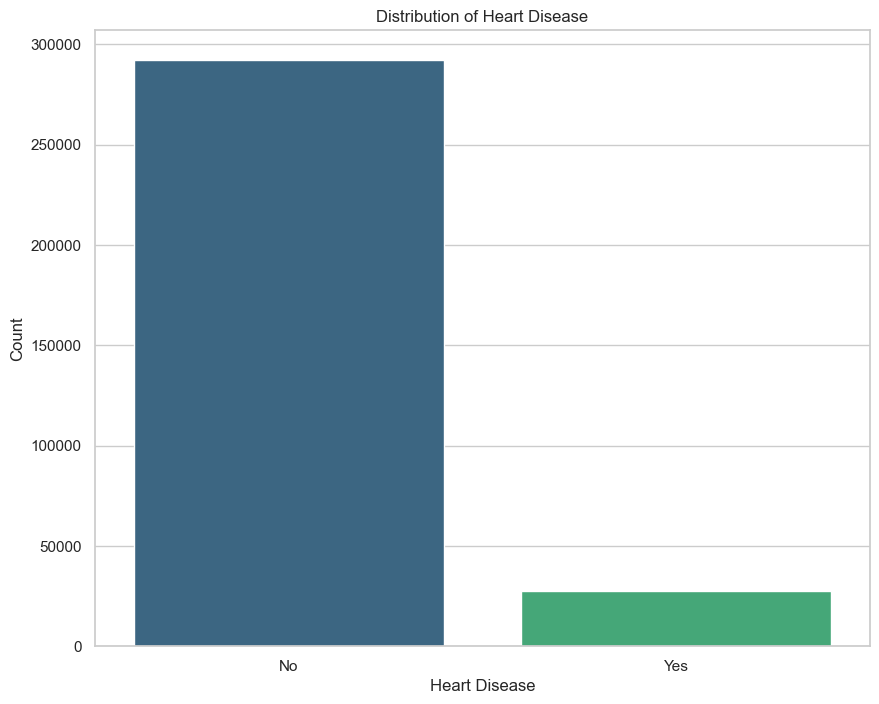

In [7]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Distribution of Heart Disease
plt.figure(figsize = (10, 8))
sns.countplot(x = 'HeartDisease', data = heart_df, hue = 'HeartDisease', palette = 'viridis', legend = False)
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

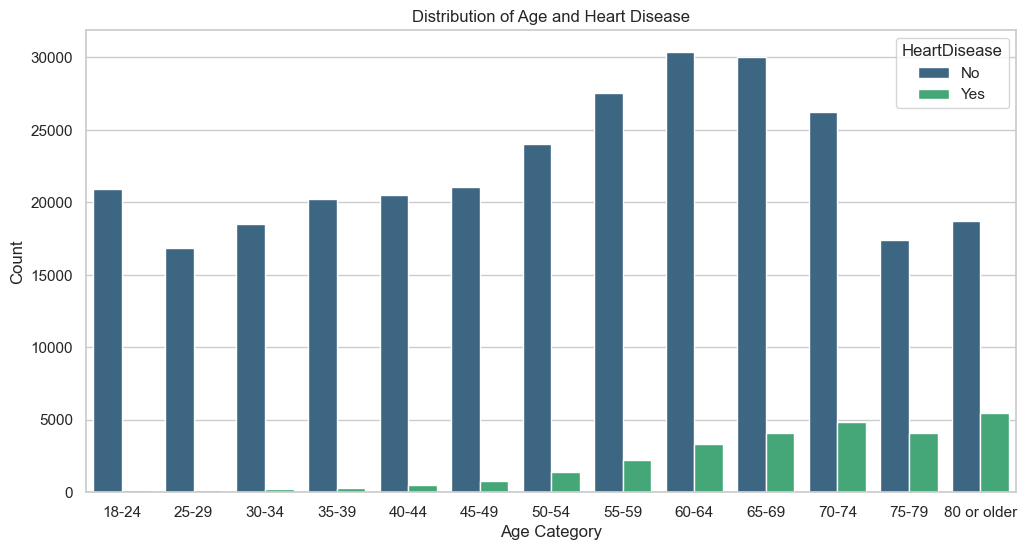

In [8]:
plt.figure(figsize = (12, 6))

# sort by age
age_order = sorted(heart_df['AgeCategory'].unique())

sns.countplot(x = 'AgeCategory', hue = 'HeartDisease', data = heart_df, order = age_order, palette = 'viridis', edgecolor = 'w')

# title and labels
plt.title('Distribution of Age and Heart Disease')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()

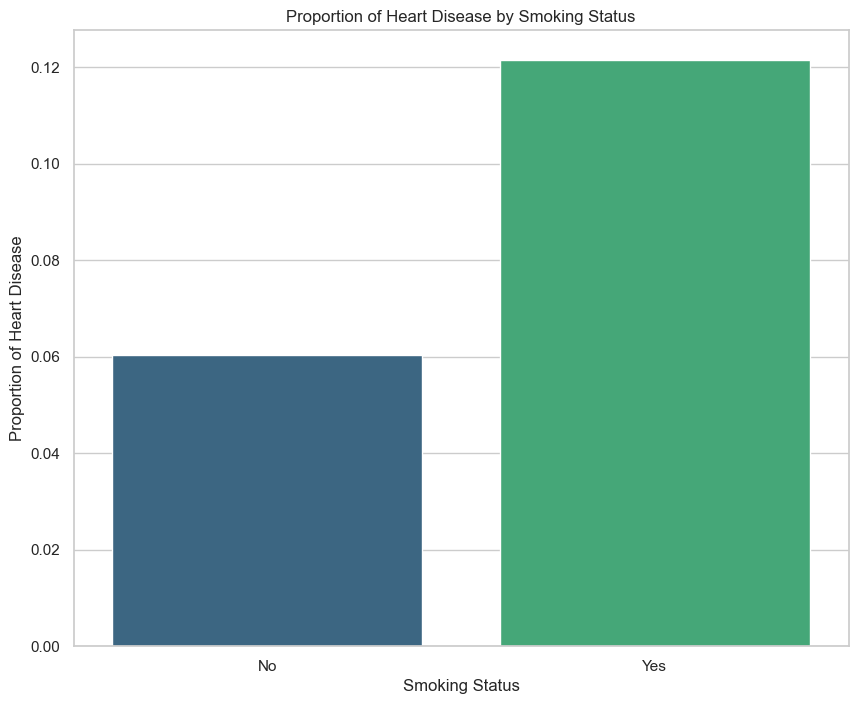

In [9]:
plt.figure(figsize = (10, 8))

# Calculate the proportion of heart disease within each smoking category
heart_disease_proportion = heart_df.groupby('Smoking')['HeartDisease'].value_counts(normalize = True).unstack().loc[:, 'Yes']

# Creates bar graph
sns.barplot(x = heart_disease_proportion.index, y = heart_disease_proportion, hue = heart_disease_proportion.index, palette = "viridis", dodge = False)

# Title and labels
plt.title('Proportion of Heart Disease by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Proportion of Heart Disease')

plt.show()

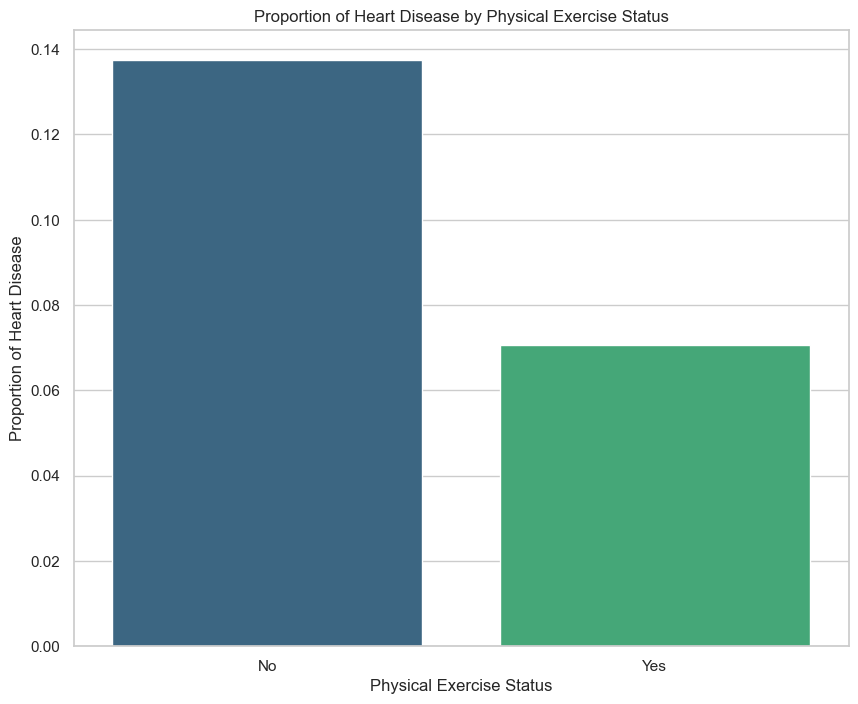

In [10]:
plt.figure(figsize = (10, 8))

# Calculate proportion of heart disease based on physical activity status 
heart_disease_proportion_exercise = heart_df.groupby('PhysicalActivity')['HeartDisease'].value_counts(normalize = True).unstack().loc[:, 'Yes']

sns.barplot(x = heart_disease_proportion_exercise.index, y = heart_disease_proportion_exercise, hue = heart_disease_proportion_exercise.index, palette = "viridis", dodge = False)

plt.title('Proportion of Heart Disease by Physical Exercise Status')
plt.xlabel('Physical Exercise Status')
plt.ylabel('Proportion of Heart Disease')

plt.show()

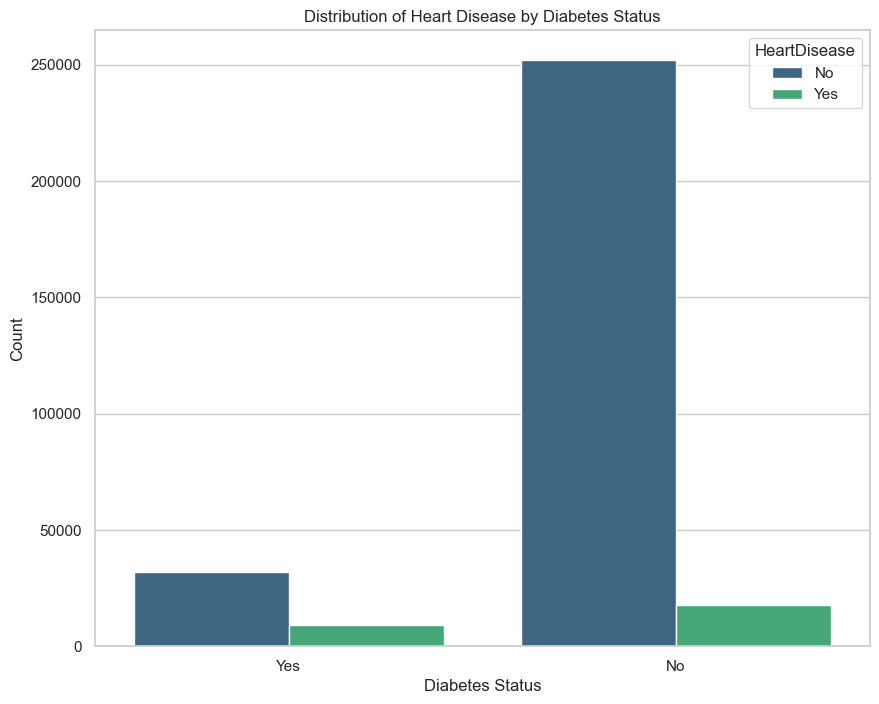

In [11]:
# Filter the DataFrame for 'Yes' and 'No' in the 'Diabetic' column
filtered_heart_df = heart_df[heart_df['Diabetic'].isin(['Yes', 'No'])]

plt.figure(figsize = (10, 8))

sns.countplot(x = 'Diabetic', hue = 'HeartDisease', data = filtered_heart_df, palette = "viridis")

plt.title('Distribution of Heart Disease by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')

plt.show()

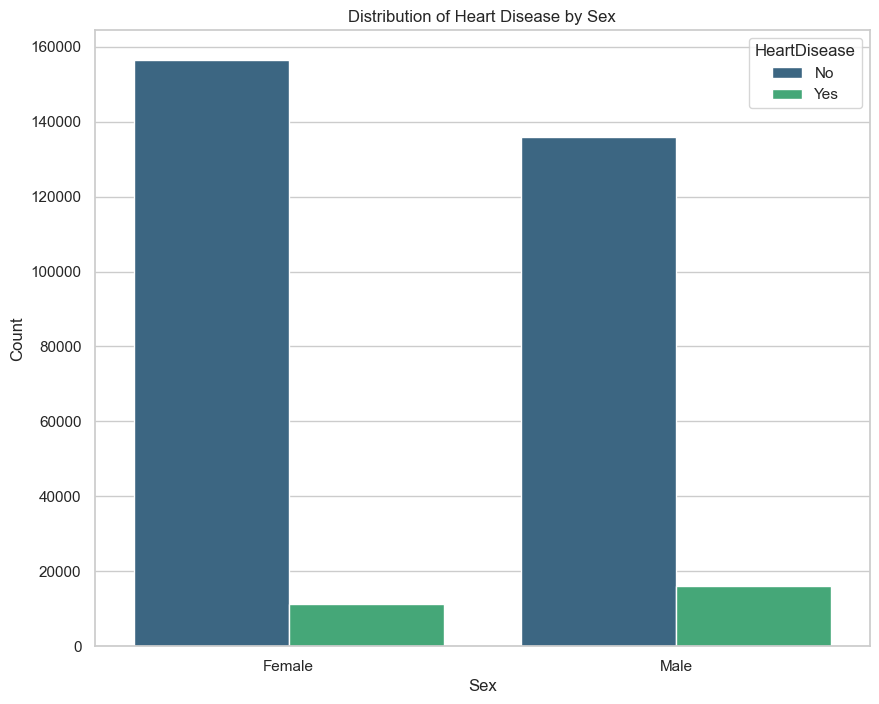

In [12]:
plt.figure(figsize = (10, 8))

sns.countplot(x = 'Sex', hue = 'HeartDisease', data = heart_df, palette = "viridis")

plt.title('Distribution of Heart Disease by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')

plt.show()

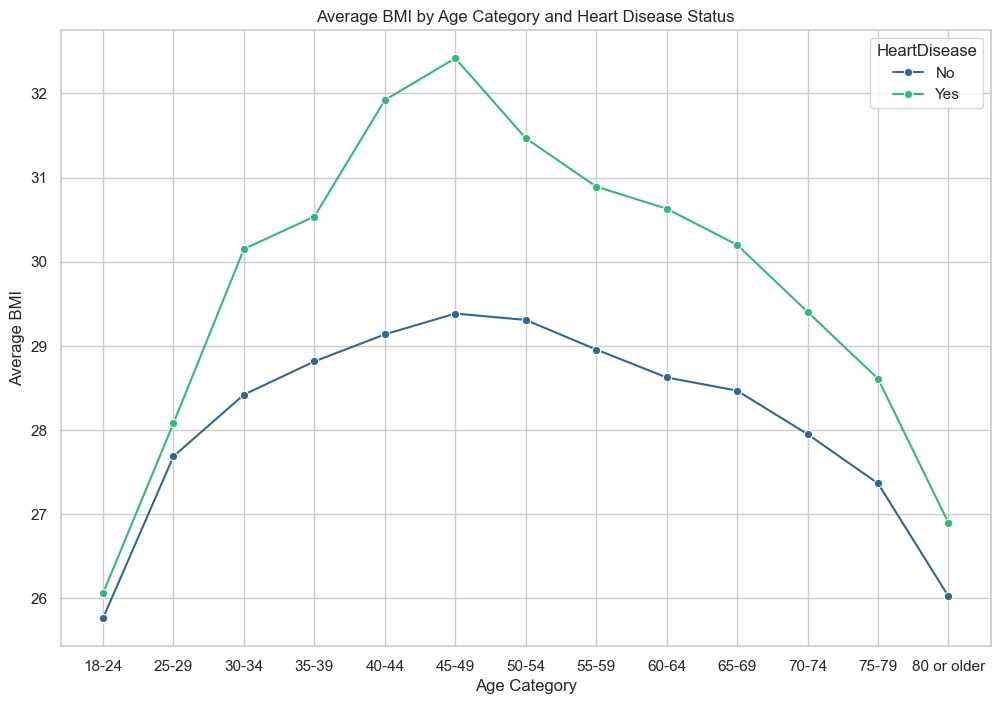

In [13]:
plt.figure(figsize = (12, 8))

# Group the data by heart disease status and age category and calculate the mean BMI
grouped_data_bmi = heart_df.groupby(['HeartDisease', 'AgeCategory'])['BMI'].mean().reset_index()

# Line plot
sns.lineplot(x = 'AgeCategory', y = 'BMI', hue = 'HeartDisease', data = grouped_data_bmi, marker = 'o', palette = 'viridis')

plt.title('Average BMI by Age Category and Heart Disease Status')
plt.xlabel('Age Category')
plt.ylabel('Average BMI')

plt.show()

## Converting data to numbers

In [14]:
heart_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [15]:
bool_to_num = {'Yes': 1, 'No': 0}

for column in heart_df.columns:
    if set(heart_df[column].unique()) == {'Yes', 'No'}:
        heart_df[column] = heart_df[column].map(bool_to_num)

heart_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,Yes,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,No,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,Yes,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,No,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,No,1,Very good,8.0,0,0,0


In [16]:
# Instantiate label encoder
label_encoder = LabelEncoder()

columns_to_encode = ['Sex','AgeCategory', 'GenHealth', 'Race', 'Diabetic']

# Loop through all columns to encode, then encode
for column in columns_to_encode:
    heart_df[column] = label_encoder.fit_transform(heart_df[column])

heart_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,4,8.0,0,0,0


## Modeling
Using Random Forest regression algorithm to handle imbalanced data

In [17]:
# Random Forest 
X = heart_df.drop("HeartDisease", axis = 1)
y = heart_df["HeartDisease"]

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

rf_clf = RandomForestClassifier(n_estimators = 10)
rf_clf.fit(X_train, y_train)

rf_clf.score(X_test, y_test)

0.9049078315796056

## Evaluation

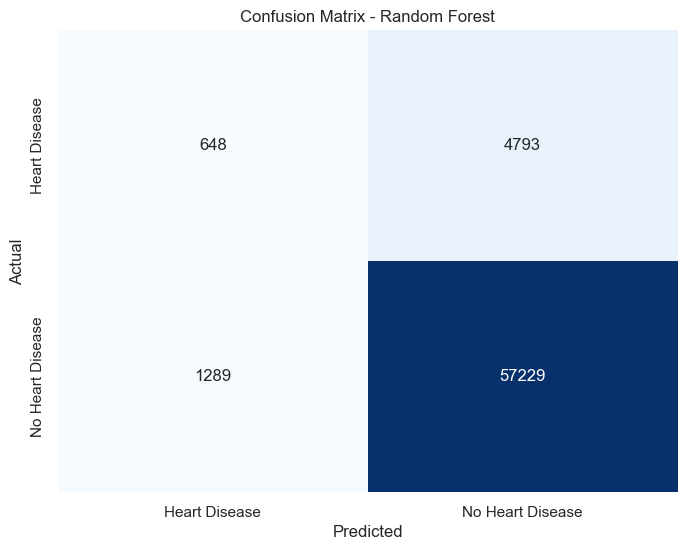

In [18]:
# Predicted outputs
y_pred = rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Flip the confusion matrix
cm_flipped = cm[::-1, ::-1]

plt.figure(figsize = (8, 6))

sns.heatmap(cm_flipped, annot = True, fmt = "d", cmap = "Blues", cbar = False, 
            xticklabels = ['Heart Disease', 'No Heart Disease'],
            yticklabels = ['Heart Disease', 'No Heart Disease'])

plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Due to the dataset's predominant instances without heart disease, we observe an increased number of false negatives.

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     58518
           1       0.33      0.12      0.18      5441

    accuracy                           0.90     63959
   macro avg       0.63      0.55      0.56     63959
weighted avg       0.87      0.90      0.88     63959



## Experimentation 
#### Class Weights, assigns higer weight to "yes heart disease" 

In [20]:
rf_clf_cw = RandomForestClassifier(n_estimators = 10, class_weight = {0: 1, 1: 5}, random_state = 24)
rf_clf_cw.fit(X_train, y_train)

rf_clf_cw.score(X_test, y_test)

0.9043606060132272

In [21]:
rf_clf_cw.score(X_test, y_test) > rf_clf.score(X_test, y_test)

False

#### Random undersampling "no heart disease"

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Apply random undersampling to the training set
rus = RandomUnderSampler(random_state = 24)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Train Random Forest on resampled data
rf_clf_rs = RandomForestClassifier(n_estimators = 10)
rf_clf_rs.fit(X_resampled, y_resampled)

rf_clf_rs.score(X_test, y_test)

0.7359402116981191

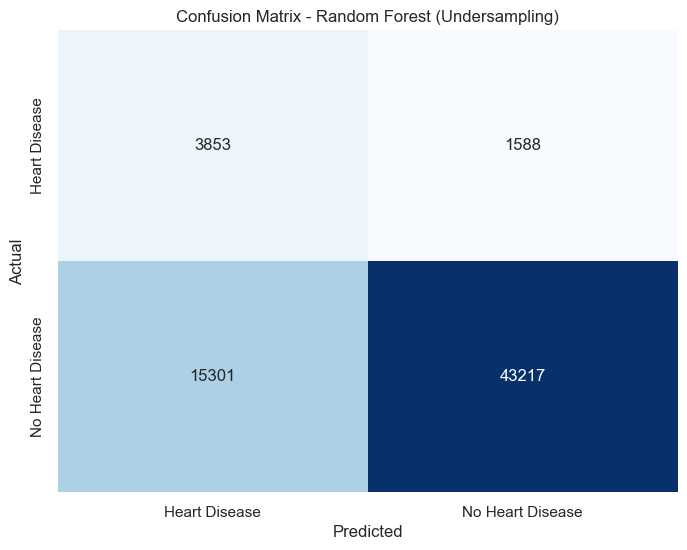

In [23]:
y_pred_rs = rf_clf_rs.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rs)

plt.figure(figsize=(8, 6))
sns.heatmap(cm[::-1, ::-1], annot = True, fmt = "d", cmap = "Blues", cbar = False,
            xticklabels = ['Heart Disease', 'No Heart Disease'],
            yticklabels = ['Heart Disease', 'No Heart Disease'])
plt.title('Confusion Matrix - Random Forest (Undersampling)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
print(classification_report(y_test, y_pred_rs))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     58518
           1       0.20      0.71      0.31      5441

    accuracy                           0.74     63959
   macro avg       0.58      0.72      0.57     63959
weighted avg       0.90      0.74      0.79     63959



#### Tuning hyper-parameters

In [25]:
# Try 100-200 in increments of 10 for n-estimators
for i in range(100, 200, 10):
    print(f"Trying model with {i} estimators...")
    model = RandomForestClassifier(n_estimators = i, random_state = 24).fit(X_train, y_train)
    print(f"Model accuracy on test set: {model.score(X_test, y_test) * 100:.2f}%")
    print("")

Trying model with 100 estimators...
Model accuracy on test set: 90.60%

Trying model with 110 estimators...
Model accuracy on test set: 90.60%

Trying model with 120 estimators...
Model accuracy on test set: 90.60%

Trying model with 130 estimators...
Model accuracy on test set: 90.63%

Trying model with 140 estimators...
Model accuracy on test set: 90.65%

Trying model with 150 estimators...
Model accuracy on test set: 90.64%

Trying model with 160 estimators...
Model accuracy on test set: 90.66%

Trying model with 170 estimators...
Model accuracy on test set: 90.68%

Trying model with 180 estimators...
Model accuracy on test set: 90.65%

Trying model with 190 estimators...
Model accuracy on test set: 90.66%



In [26]:
# Grid search on parameters 'n_estimators', 'min_samples_split', and 'min_samples_leaf'
param_grid = {'n_estimators': [2, 5, 10, 20], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2, 3]}

grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=10),
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [2, 5, 10, 20]})

In [27]:
# Gets best parameters
grid_search.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20}

In [28]:
# Train on best parameters
rf_clf = RandomForestClassifier(n_estimators = 20, min_samples_leaf = 3, min_samples_split = 3, random_state = 24)
rf_clf.fit(X_train, y_train)

rf_clf.score(X_test, y_test)

0.9155709126158945

In [29]:
# Trying a more extensive grid search 
param_grid = {'n_estimators': [20, 50, 170, 200], 'min_samples_split': [3, 4, 6], 'min_samples_leaf': [3, 5, 8]}

grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 170}

In [30]:
# Best estimators from grid search
rf_clf = RandomForestClassifier(n_estimators = 50, min_samples_leaf = 5, min_samples_split = 6, random_state = 24)
rf_clf.fit(X_train, y_train)

rf_clf.score(X_test, y_test)

0.9160712331337263

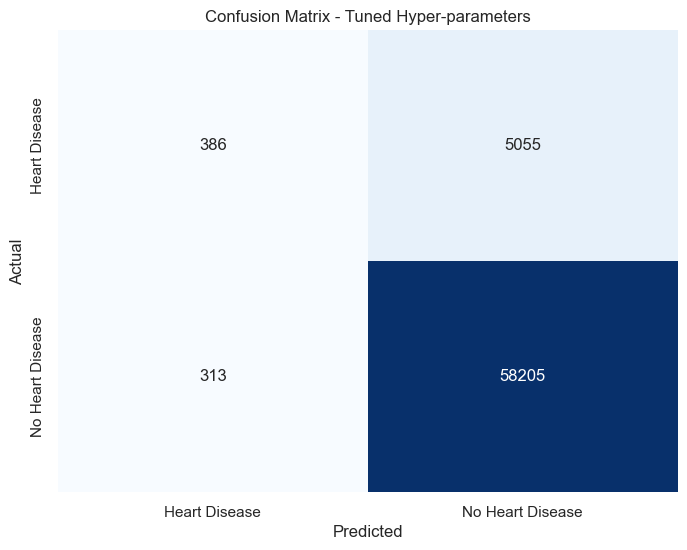

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     58518
           1       0.55      0.07      0.13      5441

    accuracy                           0.92     63959
   macro avg       0.74      0.53      0.54     63959
weighted avg       0.89      0.92      0.89     63959



In [31]:
y_pred = rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm[::-1, ::-1], annot = True, fmt = "d", cmap = "Blues", cbar = False,
            xticklabels = ['Heart Disease', 'No Heart Disease'],
            yticklabels = ['Heart Disease', 'No Heart Disease'])
plt.title('Confusion Matrix - Tuned Hyper-parameters')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))

In [32]:
# Parameters to optimize
param_dist = {
    'n_estimators': np.random.randint(10, 100, size = 10),  
    'max_depth': [None, 10, 20, 30, 40, 50],  
    'min_samples_split': np.random.randint(2, 100, size = 13),  
    'min_samples_leaf': np.random.randint(1, 100, size = 13),   
    'class_weight': [{0: 1, 1: w} for w in [5, 15, 20, 30, 50]]  
}

rf_clf = RandomForestClassifier(random_state = 24)

random_search = RandomizedSearchCV(rf_clf, param_distributions = param_dist, n_iter = 10, cv = 5, scoring = 'f1', n_jobs = -1, random_state = 24)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_rf_clf_random = random_search.best_estimator_

best_rf_clf_random_score = best_rf_clf_random.score(X_test, y_test)
print("Best Model Score:", best_rf_clf_random_score)

y_pred_best_random = best_rf_clf_random.predict(X_test)

Best Parameters: {'n_estimators': 66, 'min_samples_split': 25, 'min_samples_leaf': 41, 'max_depth': 40, 'class_weight': {0: 1, 1: 5}}
Best Model Score: 0.8509982957832362


#### Best Hyperparameters

After conducting a grid search, the following hyperparameters were identified as the best for the Random Forest model:

- `n_estimators`: 50
- `min_samples_split`: 5
- `min_samples_leaf`: 6

#### Data Downsampling: Balancing Heart Disease Instances

In [33]:
np.random.seed(24)
heart_disease_index = heart_df[heart_df['HeartDisease'] == 0].index

# Randomly select 150000 thousand rows
random_rows_remove = np.random.choice(heart_disease_index, size = 150000, replace = False)

# Remove the selected rows
heart_df_down_scaled = heart_df.drop(index = random_rows_remove)

# Check Shape and counts
print(f"Original DataFrame shape: {heart_df.shape}")
print(f"Updated DataFrame shape: {heart_df_down_scaled.shape}")
print("\nThe distribution of 'HeartDisease' in the original DataFrame:")
print(heart_df["HeartDisease"].value_counts())
print("\nThe distribution of 'HeartDisease' in the updated DataFrame:")
print(heart_df_down_scaled["HeartDisease"].value_counts())

Original DataFrame shape: (319795, 18)
Updated DataFrame shape: (169795, 18)

The distribution of 'HeartDisease' in the original DataFrame:
HeartDisease
0    292422
1     27373
Name: count, dtype: int64

The distribution of 'HeartDisease' in the updated DataFrame:
HeartDisease
0    142422
1     27373
Name: count, dtype: int64


In [34]:
# Split down scaled data
X_rs = heart_df_down_scaled.drop("HeartDisease", axis = 1)
y_rs = heart_df_down_scaled["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.2, random_state = 24)

# Train new data set
rf_clf = RandomForestClassifier(n_estimators = 50, min_samples_leaf = 5, min_samples_split = 6, random_state = 24)
rf_clf.fit(X_train, y_train)

rf_clf.score(X_test, y_test)

0.8523513648811802

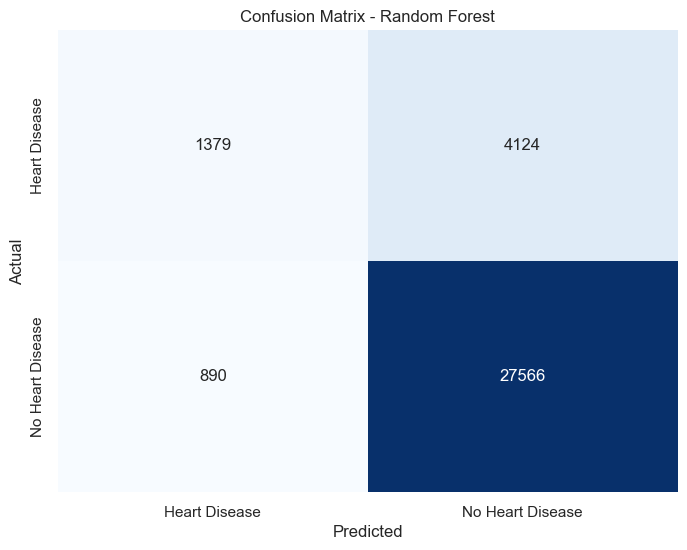

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     28456
           1       0.61      0.25      0.35      5503

    accuracy                           0.85     33959
   macro avg       0.74      0.61      0.64     33959
weighted avg       0.83      0.85      0.83     33959



In [35]:
# Predictions on the test set
y_preds = rf_clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm[::-1, ::-1], annot = True, fmt = "d", cmap = "Blues", cbar = False,
            xticklabels = ['Heart Disease', 'No Heart Disease'],
            yticklabels = ['Heart Disease', 'No Heart Disease'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_preds))

In [36]:
# Cross validation, split in 5
cv_scores = cross_val_score(rf_clf, X, y, cv = 5, scoring = 'accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("")

cv_scores_r = cross_val_score(rf_clf, X_rs, y_rs, cv = 5, scoring = 'accuracy')

print("Cross-Validation Scores (reduced data):", cv_scores_r)
print("Mean Cross-Validation Score (reduced data):", cv_scores_r.mean())

Cross-Validation Scores: [0.91502369 0.91525821 0.91525821 0.91546147 0.91557091]
Mean Cross-Validation Score: 0.9153144983505058

Cross-Validation Scores (reduced data): [0.85296976 0.85061398 0.85276363 0.85135016 0.85167408]
Mean Cross-Validation Score (reduced data): 0.8518743190317736


## Summary

**1. Key Findings:**
   - The best-trained model achieved an accuracy of approximately 91.6%, providing a reliable predictive capability for heart disease.
   - The precision-recall-f1 score evaluation suggests that while the model performs exceptionally well in identifying cases without heart disease (Class 0), it faces challenges in correctly classifying positive cases (Class 1).
   - Smoking is identified as a significant factor contributing to heart disease, as it causes the proportion of heart disease cases to double.
   - Engaging in physical activity appears to have a protective effect, reducing the proportion of heart disease cases by a noticeable amount.
   - Individuals with a higher BMI exhibit a higher likelihood of heart disease, indicating that BMI is positively correlated with the risk of developing heart-related issues.

**2. Insights:**
   - The analysis reveals a stark contrast in heart disease risk between smokers and non-smokers, emphasizing the importance of lifestyle choices.
   - Physical activity emerges as a crucial factor in mitigating heart disease risk, reinforcing the significance of regular exercise.
   - The correlation between BMI and heart disease highlights the need for weight management as a preventive measure.

**3. Limitations:**
   - The dataset exhibits a notable imbalance, with a significantly larger number of samples labeled as "No heart disease" compared to "Yes heart disease." This imbalance could impact the model's performance, particularly in detecting positive cases.

**4. Next Steps:**
   - Address data bias by collecting additional samples for individuals with heart disease to create a more balanced dataset.
   - Explore advanced techniques, such as oversampling or undersampling, to mitigate the impact of data imbalance on model training.

**5. Acknowledgments:**
   - The dataset used in this analysis was obtained from Kaggle, with appreciation for the contribution of Kamil Pytlak. The dataset link is [here](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease).

This comprehensive summary provides a clear overview of the key findings, insights, limitations, next steps, and acknowledgments derived from the analysis of personal key indicators of heart disease.
